In [242]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import torch
import torchtext
from torchtext import data
import spacy
import os
import pickle
import sys
sys.path.insert(1, '../src/siamese_triplet')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

spacy_en = spacy.load('en')
SEED = 1234


In [120]:
TEXT = data.Field(lower=True,include_lengths=False, tokenize = 'spacy')

LABEL = data.Field( dtype = torch.int)

dataFields = {'content': ('content', TEXT), 
              'author_label': ('author_label', LABEL)}

In [121]:
data_dir = '../data/processed/'
data_name = 'longest_poems.json'

In [122]:
dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [135]:
import random
SEED = 3
train_data, valid_data = dataset.split(split_ratio=0.8,random_state = random.seed(SEED))



In [136]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(dataset, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [137]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()



### New way tokenizing and batching

In [138]:
import spacy
nlp = spacy.load('en')

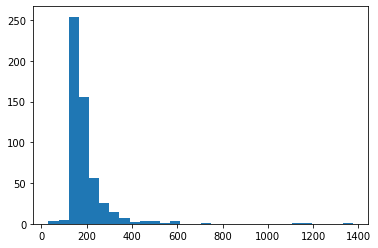

In [139]:
len_train = [len(i.content) for i in train_data.examples]
plt.hist(len_train,bins=30)
plt.show()

In [140]:

def pad_to_n(ls, n ):
    """ls list to be cut/padded to length n"""
    ls= ls[:n]
    if len(ls)<n: ls=(['<pad>']*(n-len(ls))) + ls
    return ls

In [229]:
aux= [i.content for i in train_data.examples ]


In [156]:
#Tokenize and save
FIX_WORD_LENGTH = 101
token2index_dic = TEXT.vocab.stoi

def token2index(token_list, token2index_dic):
    return [token2index_dic[i] for i in  token_list]

def index_pad_data(data, fixed_word_length, token2index_dir):  
    data = [pad_to_n(i, fixed_word_length) for i in data]
    indexed = [token2index(t,token2index_dir ) for t in data] 
    return indexed

def tokenize_and_save(data, fixed_text_length, token2index_dir, data_dir, file_name):
  
    data_list = [i.content for i in data.examples]
    labels_list = [i.author_label for i in data.examples]
    data_list = index_pad_data(data_list, fixed_text_length, token2index_dir)
    with open(data_dir+file_name, 'wb') as f:
        pickle.dump((data_list,labels_list), f)

In [157]:
tokenized_train_data = 'longest10_train.pkl'
tokenized_valid_data = 'longest10_valid.pkl'
tokenize_and_save(train_data, FIX_WORD_LENGTH, token2index_dir, data_dir, tokenized_train_data)
tokenize_and_save(valid_data, FIX_WORD_LENGTH, token2index_dir, data_dir, tokenized_valid_data)

In [158]:
with open(data_dir + tokenized_train_data, 'rb') as f:
    train_data_, train_labels_ = pickle.load(f)

with open(data_dir + tokenized_valid_data, 'rb') as f:
    valid_data_, valid_labels_ = pickle.load(f)

In [161]:
def to_Loader(data,labels):
    """
    data : list of integer corresponding to tokens
    labels: author (index) corresponding to each entry in data
    """
    data = [torch.LongTensor(i) for i in data]
    data = torch.stack(data)
    labels= torch.Tensor(labels)
    return data, labels

In [235]:
torch.stack([torch.Tensor([1,2]), torch.Tensor([1,2])]) 

tensor([[1., 2.],
        [1., 2.]])

In [243]:
from datasets import BalancedBatchSampler
#Turn list to tensors
train_data_tensor, train_labels_tensor= to_Loader(train_data_, train_labels_)
#Balance sampler
train_batch_sampler = BalancedBatchSampler(train_labels_tensor, n_classes=10, n_samples=10)
#Turn tensor into tensor dataset
train_tensordataset = torch.utils.data.TensorDataset(train_data_tensor, train_labels_tensor)
#Turn dataset into Loader
train_Loader=torch.utils.data.DataLoader(train_tensordataset, sampler=train_batch_sampler, pin_memory=True)

In [244]:
from datasets import BalancedBatchSampler
#Turn list to tensors
valid_data_tensor, valid_labels_tensor= to_Loader(valid_data_, valid_labels_)
#Balance sampler
valid_batch_sampler = BalancedBatchSampler(valid_labels_tensor, n_classes=10, n_samples=10)
#Turn tensor into tensor dataset
valid_tensordataset = torch.utils.data.TensorDataset(valid_data_tensor, valid_labels_tensor)
#Turn dataset into Loader
valid_Loader=torch.utils.data.DataLoader(valid_tensordataset, sampler=valid_batch_sampler, pin_memory=True)

## Plotting function

In [200]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
    
def extract_embeddings(dataloader, model, emb_dim):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), emb_dim))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for poems, target in dataloader:
            poems = poems.squeeze()
            poems_le= len(poems)
            if cuda:
                poems = poems.cuda()

            embeddings[k:k+poems_le] = model.get_embedding(poems).data.cpu().numpy()
            
            labels[k:k+poems_le] = target.numpy()
            k += poems_le
    return embeddings, labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    if save_plot!=None:
        plt.savefig('../media/'+save_plot)

In [187]:
#train_embeddings_otl, train_labels_otl = extract_embeddings(training_Loader, MODEL,2)

## Build the Model



In [188]:
sys.path.insert(1, '../src/')
from models import FastText, CNN

In [189]:
INPUT_DIM = len(TEXT.vocab)
WORD_EMBEDDING_DIM = 100 #Fixed by preloaded embedding 

AUTHOR_DIM = 2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model = FastText(INPUT_DIM, WORD_EMBEDDING_DIM, AUTHOR_DIM, PAD_IDX)


INPUT_DIM = len(TEXT.vocab)
WORD_EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
AUTHOR_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, WORD_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, AUTHOR_DIM, DROPOUT, PAD_IDX)


pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(WORD_EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(WORD_EMBEDDING_DIM)

In [245]:
# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric


import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from train import fit, simplified_fit
import numpy as np
cuda = torch.cuda.is_available()


MARGIN = 0.25
embedding_net = EmbeddingNet()

#embedding_net = CNN_net # Uncomment to comeback to original version 
#MODEL = embedding_net
MODEL= model

MODEL = MODEL.to(device)
loss_fn = OnlineTripletLoss(MARGIN, RandomNegativeTripletSelector(MARGIN))
LR = 5e-3 

optimizer = optim.Adam(MODEL.parameters(), lr=LR, weight_decay=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 15
log_interval = 4




In [191]:
simplified_fit(train_Loader, None, MODEL, loss_fn, optimizer, 
    n_epochs, cuda, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/540 (0%)]	Loss: 0.652214	Average nonzero triplets: 450.0
Train: [200/540 (40%)]	Loss: 0.646691	Average nonzero triplets: 450.0
Train: [400/540 (80%)]	Loss: 0.655347	Average nonzero triplets: 450.0
Epoch: 1/15. Train set: Average loss: 0.6513	Average nonzero triplets: 450.0
Train: [0/540 (0%)]	Loss: 0.604158	Average nonzero triplets: 450.0
Train: [200/540 (40%)]	Loss: 0.534425	Average nonzero triplets: 449.3333333333333
Train: [400/540 (80%)]	Loss: 0.437952	Average nonzero triplets: 449.6
Epoch: 2/15. Train set: Average loss: 0.5098	Average nonzero triplets: 449.6
Train: [0/540 (0%)]	Loss: 0.327880	Average nonzero triplets: 450.0
Train: [200/540 (40%)]	Loss: 0.348167	Average nonzero triplets: 449.6666666666667
Train: [400/540 (80%)]	Loss: 0.359331	Average nonzero triplets: 449.8
Epoch: 3/15. Train set: Average loss: 0.3486	Average nonzero triplets: 449.8
Train: [0/540 (0%)]	Loss: 0.311864	Average nonzero triplets: 450.0
Train: [200/540 (40%)]	Loss: 0.304648	Average nonzero tri

# Plotting time

In [192]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=1)#, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    if save_plot!=None:
        plt.savefig('../media/'+save_plot)

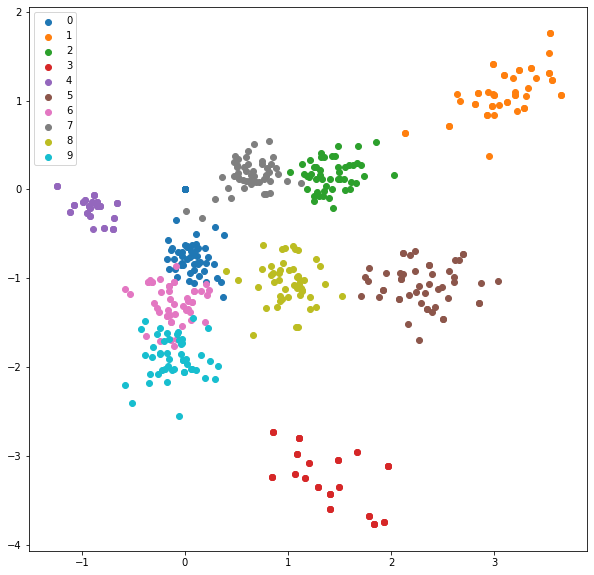

In [193]:
train_embeddings_otl, train_labels_otl = extract_embeddings(training_Loader, MODEL, AUTHOR_DIM)
plot_embeddings(train_embeddings_otl, train_labels_otl, save_plot='training.png')

In [205]:
iter(valid_Loader)

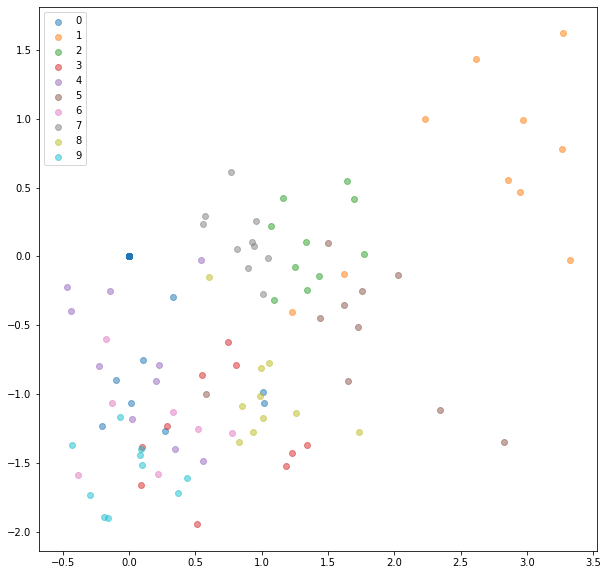

In [238]:
valid_embeddings_otl, valid_labels_otl = extract_embeddings(valid_Loader, MODEL, AUTHOR_DIM)
plot_embeddings(valid_embeddings_otl, valid_labels_otl,save_plot='testing.png')

In [239]:
from sklearn.neighbors import KNeighborsClassifier as KNC
KNN = KNC(n_neighbors=3)
KNN.fit(train_embeddings_otl, train_labels_otl)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [241]:
KNN.score(valid_embeddings_otl,valid_labels_otl)

0.674074074074074